In [1]:
import pandas as pd
fraud = pd.read_csv('onlinefraud.csv',nrows=10000)

In [2]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#Check for Null Values

fraud.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
encoding = pd.get_dummies(fraud, columns=['type'], drop_first=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

encoding[columns_to_scale] = scaler.fit_transform(encoding[columns_to_scale])

In [6]:
import sqlite3

conn = sqlite3.connect('onlinefraud.db')


encoding.to_sql('transactions', conn, if_exists='replace', index=False)

10000

## Exploratory Data Analysis

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
fraud_count = fraud['isFraud'].value_counts()

fraud_count

isFraud
0    9932
1      68
Name: count, dtype: int64

In [24]:
x  = 68 / 9932

x


0.00684655658477648

#### This means that only .6% of payments were fraudulent!

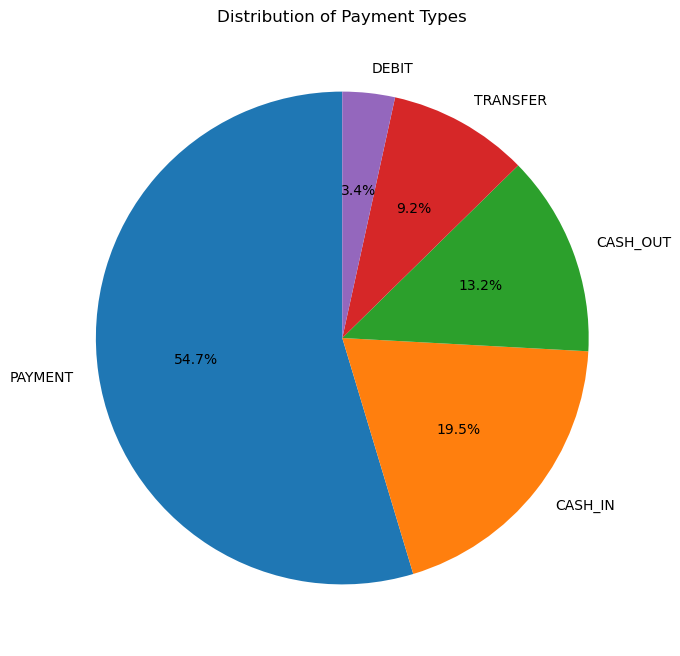

In [10]:
payment_counts = fraud['type'].value_counts()

plt.figure(figsize=(8, 8))  

plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)

plt.title("Distribution of Payment Types")
plt.savefig("plot#1.png", dpi=300, bbox_inches="tight")
plt.show()


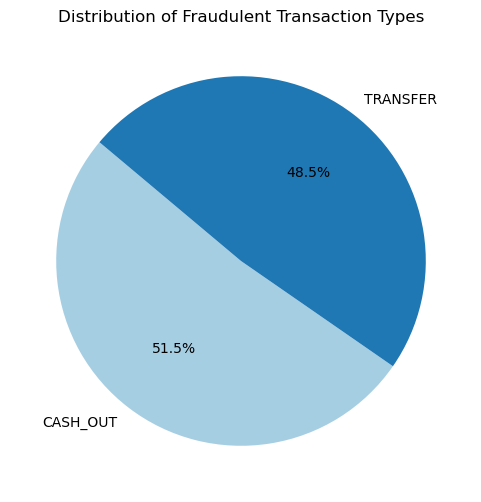

In [28]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect("onlinefraud.db")

# SQL query to count the different types of fraudulent transactions
query = """
SELECT type, COUNT(*) AS count
FROM fraud_transactions
WHERE isFraud = 1
GROUP BY type;
"""

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(df['count'], labels=df['type'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

plt.title("Distribution of Fraudulent Transaction Types")
plt.savefig("plot#2.png", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
import sqlite3

conn = sqlite3.connect('onlinefraud.db') 

fraud.to_sql('fraud_transactions', conn, index=False, if_exists='replace')

conn.execute('CREATE INDEX IF NOT EXISTS idx_isFraud ON fraud_transactions(isFraud);')

query = """
SELECT isFraud, 
       AVG(amount) AS avg_amount, 
       AVG(oldbalanceOrg) AS avg_oldbalanceOrg,
       AVG(newbalanceOrig) AS avg_newbalanceOrig
FROM fraud_transactions
GROUP BY isFraud;
"""

fraud_by_type_sql = pd.read_sql(query, conn)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of variables to plot
variables = ['avg_amount', 'avg_oldbalanceOrg', 'avg_newbalanceOrig']
titles = ['Average Amount', 'Average Old Balance', 'Average New Balance']


for i, var in enumerate(variables):
    ax = axes[i]
    
    data = fraud_by_type_sql.groupby('isFraud')[var].mean()
    
    ax.bar(['Legitimate', 'Fraudulent'], data, color=['green', 'red'])
    
    ax.set_title(titles[i], fontsize=14)
    
    ax.set_xlabel('Fraud Status (0=Legitimate, 1=Fraudulent)', fontsize=12)
    
    ax.set_ylabel(f'Average {titles[i]}', fontsize=12)
    
    ax.set_ylim(0, data.max() * 1.2)

plt.tight_layout()

plt.show()
plt.savefig("plot#3.png", dpi=300, bbox_inches="tight")

conn.close()


### Interesting! We've scaled the data, which is why the values range from 0 to 1. 

### It's very clear that fraudulent transactions have much higher amounts than legitimate ones. Additionally, fraudulent transactions leave much lower newer balances compared to legitimate ones.

#### Another interesting note, it appears that fraudulent transactions happen to people with lower balances. Interesting note

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

try:
    df = pd.DataFrame(fraud)
    fraud_by_step = df.groupby(['step', 'isFraud']).size().unstack().fillna(0)

    plt.figure(figsize=(12, 6))

    # Non-Fraud Cases
    plt.subplot(1, 2, 1)
    
    sns.lineplot(data=fraud_by_step[0], marker='o', color='blue')
    
    plt.title('Non-Fraud Cases Over Time (Steps)')
    
    plt.xlabel('Step')
    
    plt.ylabel('Number of Non-Fraud Transactions')

    # Fraud Cases
    plt.subplot(1, 2, 2)
    
    sns.lineplot(data=fraud_by_step[1], marker='o', color='red')
    
    plt.title('Fraud Cases Over Time (Steps)')
    
    plt.xlabel('Step')
    
    plt.ylabel('Number of Fraud Transactions')

    plt.tight_layout()
    
    plt.savefig("plot#4.png", dpi=300, bbox_inches="tight")
    
    plt.show()

except Exception as e:
    print("Error occurred:", e)


### Interesting! It seems that the majority of fraud cases happened in Step 6. Since there are 7 steps, I'm assuming that each step represents 1 day

### That means that a majority of fraud cases happened on Saturday

In [ ]:
# Scatter plot of fraud vs origin account balance
%matplotlib inline
sns.scatterplot(x='oldbalanceOrg', y='amount', hue='isFraud', data=fraud, palette='coolwarm', s=100)

plt.title('Fraud vs Origin Account Balance')

plt.xlabel('Old Balance (Origin)')

plt.ylabel('Transaction Amount')
plt.tight_layout()
plt.savefig("plot#5.png", dpi=300, bbox_inches="tight")
plt.show()


### Interesting! Notice how the 2 big balances had big fraudulent transactions!


## Now it's time develop predictive models

### Logistic Regression

In [15]:
#Import libraries
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, roc_auc_score

In [16]:
# One hot encoding
X = encoding.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = encoding['isFraud']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


data = pd.read_csv('onlinefraud.csv',nrows=5000)
data = data.drop(['nameOrig', 'nameDest'], axis=1)

data = pd.get_dummies(data, columns=['type'], drop_first=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])


X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)  
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, lr_preds))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1488
           1       0.00      0.00      0.00        12

    accuracy                           0.99      1500
   macro avg       0.50      0.50      0.50      1500
weighted avg       0.98      0.99      0.99      1500



/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


print("Random Forest Report:")
print(classification_report(y_test, rf_preds))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])}")


Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1488
           1       1.00      0.50      0.67        12

    accuracy                           1.00      1500
   macro avg       1.00      0.75      0.83      1500
weighted avg       1.00      1.00      1.00      1500

AUC-ROC Score: 0.9998039874551972


#### While this is better, it can only identify fraudulent transactions at a 50% rate. Let's work on this and improve it by adding SMOTE

##### Why am I using SMOTE? Since this is fraudulent transaction data set, very few transactions are fraudulent, meaning the dataset is highly imbalanced. SMOTE stands for Synthetic Minority Oversampling Technique, where it is used for balancing an imbalanced dataset by creating new minority cases(I.E. making up synthetic fraud cases)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. Oversample the Minority Class (SMOTE)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 2. Adjust Class Weights
rf_model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10})

# 3. Perform Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train_resampled, y_train_resampled)

# Use the best model
best_rf_model = grid_search.best_estimator_

# 4. Evaluate the Best Model
rf_preds = best_rf_model.predict(X_test)
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, rf_preds))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_probs)}")

# 5. Adjust Prediction Threshold for Recall
threshold = 0.3
rf_preds_threshold = (rf_probs >= threshold).astype(int)
print("Random Forest Report (Adjusted Threshold):")
print(classification_report(y_test, rf_preds_threshold))
print(f"AUC-ROC Score (Adjusted Threshold): {roc_auc_score(y_test, rf_probs)}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1488
           1       0.59      0.83      0.69        12

    accuracy                           0.99      1500
   macro avg       0.79      0.91      0.84      1500
weighted avg       1.00      0.99      0.99      1500

AUC-ROC Score: 0.9972278225806451
Random Forest Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1488
           1       0.50      0.92      0.65        12

    accuracy                           0.99      1500
   macro avg       0.75      0.95      0.82      1500
weighted avg       1.00      0.99      0.99      1500

AUC-ROC Score (Adjusted Threshold): 0.9972278225806451


###
Default Threshold (0.5)
Metrics Breakdown:

    Precision (1): 0.59
        Of all transactions predicted as fraud, 59% were actually fraudulent.
        There are some false positives, but it’s reasonable given the recall improvement.

    Recall (1): 0.83
        The model successfully identified 83% of fraudulent transactions.
        This is a significant improvement over the previous models, reducing the number of false negatives (missed frauds).

    F1-Score (1): 0.69
        A harmonic mean of precision and recall for fraudulent transactions. A higher F1-score indicates a good balance between precision and recall.

    AUC-ROC Score: 0.9972
        The model has excellent discriminatory power, distinguishing between legitimate and fraudulent transactions very well, and beats our goal of building a model with a higher accuracy rate than 0.9931534434152235!!!

Adjusted Threshold (0.3)
Metrics Breakdown:

    Precision (1): 0.50
        Precision dropped because lowering the threshold leads to more transactions being predicted as fraud (increasing false positives).

    Recall (1): 0.92
        Recall increased to 92%, meaning the model now catches nearly all fraudulent transactions.
        This is critical in scenarios where missing a fraudulent transaction is costlier than a false alarm.

    F1-Score (1): 0.65
        The F1-score slightly dropped due to the trade-off between precision and recall, but recall improvement compensates for this.

    Accuracy:
        Accuracy remains very high (99%), but it’s less informative due to class imbalance (legitimate transactions dominate).

    AUC-ROC Score: 0.9972
        The AUC-ROC score remains unchanged, as it evaluates the model's ability to rank predictions rather than its classification threshold.

Key Insights

    Default Threshold (0.5):
        Good balance between precision and recall.
        Better suited for scenarios where precision is as important as recall (e.g., avoiding false positives to minimize investigation costs).

    Adjusted Threshold (0.3):
        High recall ensures nearly all fraudulent transactions are identified.
        Ideal for scenarios where missing fraud (false negatives) has a significant cost or risk.

### Simulating a transaction

In [21]:
# Simulate a transaction
new_transaction = {
    'step': 5,
    'amount': 5000,
    'oldbalanceOrg': 20000,
    'newbalanceOrig': 15000,
    'oldbalanceDest': 0,
    'newbalanceDest': 0,
    'type_CASH_OUT': 0,
    'type_PAYMENT': 1,
    'type_TRANSFER': 0,
    'type_DEBIT': 0,
    'type_DEPOSIT': 0
}

# Convert to DataFrame
new_transaction_df = pd.DataFrame([new_transaction])

# Normalize numerical data
new_transaction_df[columns_to_scale] = scaler.transform(new_transaction_df[columns_to_scale])

# Predict fraud
# Ensure the transaction data has the same columns as the training data
# Get the columns from the training data
columns_in_training = X_train.columns  

# Ensure new transaction has the same columns
new_transaction_df = new_transaction_df[columns_in_training]

# Normalize numerical data (only scale numerical features that were scaled during training)
new_transaction_df[columns_to_scale] = scaler.transform(new_transaction_df[columns_to_scale])

# Predict fraud
fraud_prediction = best_rf_model.predict(new_transaction_df)
print("Fraud Detected!" if fraud_prediction[0] == 1 else "Transaction Safe")



Transaction Safe


### Since we have built a model that beats our standard and has a high F-1 Score and recall score, we can move on to testing out other methods

### Testing out Neural Networks

In [22]:
# Importing necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

data = pd.read_csv('onlinefraud.csv',nrows=10000)

# Drop unnecessary columns 
data = data.drop(['nameOrig', 'nameDest'], axis=1)

# Convert categorical columns to one-hot encoding
data = pd.get_dummies(data, columns=['type'], drop_first=True)

# Split the dataset into features (X) and target variable (y)
X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1) 
y = data['isFraud']  # Target (Fraud: 1, Not Fraud: 0)

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features (Scale them to range between 0 and 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Build the Neural Network Model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid because it's a binary classification problem

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the validation data
y_val_pred = model.predict(X_val_scaled)
y_val_pred = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary (fraud or not)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

2024-12-10 03:48:07.001861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 03:48:07.008649: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 03:48:07.019690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733802487.039211 2562674 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733802487.044813 2562674 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 03:48:07.069227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/10


/home/sb2116/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-10 03:48:09.164442: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8494 - loss: 0.3331 - val_accuracy: 0.9905 - val_loss: 0.0444
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9939 - loss: 0.0393 - val_accuracy: 0.9905 - val_loss: 0.0385
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9933 - loss: 0.0319 - val_accuracy: 0.9905 - val_loss: 0.0359
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9954 - loss: 0.0212 - val_accuracy: 0.9910 - val_loss: 0.0341
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9934 - loss: 0.0264 - val_accuracy: 0.9920 - val_loss: 0.0328
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9921 - loss: 0.0294 - val_accuracy: 0.9920 - val_loss: 0.0320
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9944 - loss: 0.0227 - val_accuracy: 0.9920 - val_loss: 0.0309
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9943 - loss: 0.0226 - val_accuracy: 0.9920 - val_

1. Accuracy:

    0.992 (99.2%) means the model correctly classified 99.2% of the transactions, which suggests it's a high-performing model overall. However, accuracy can be misleading when the dataset is imbalanced (like fraud detection where fraudulent transactions are rare). 

2. Precision:
    Precision is the ratio of true positives (correctly predicted fraud transactions) to all predicted positives (all transactions predicted as fraud).
    For Class 0 (Non-Fraud):
        Precision = 0.99, meaning that 99% of transactions predicted as non-fraud were actually non-fraud.
    For Class 1 (Fraud):
        Precision = 1.00, meaning that 100% of transactions predicted as fraud were actually fraud. This is ideal, indicating no false positives for fraud predictions.

3. Recall:
    Recall is the ratio of true positives (correctly predicted fraud transactions) to all actual positives (all fraud transactions in the dataset).
    For Class 0 (Non-Fraud):
        Recall = 1.00, meaning the model correctly identified all non-fraudulent transactions.
    For Class 1 (Fraud):
        Recall = 0.16, meaning that only 16% of actual fraud transactions were correctly identified by the model. This is a low recall for fraud detection, meaning the model misses most of the fraudulent transactions. This is a major concern because it means the model is failing to detect many fraudulent transactions.

4. F1-Score:
    F1-score is the harmonic mean of precision and recall, and it gives a single metric that balances the two. It’s particularly useful when dealing with imbalanced datasets.
    For Class 0 (Non-Fraud):
        F1-score = 1.00, indicating perfect performance on detecting non-fraudulent transactions.
    For Class 1 (Fraud):
        F1-score = 0.27, which is very low. This indicates that even though the precision is perfect (no false positives for fraud), the recall is very low, meaning the model misses a lot of fraud cases.

5. Support:
    Support represents the number of true instances for each class (the number of actual non-fraud and fraud transactions in the dataset).
    For Class 0 (Non-Fraud):
        Support = 1981, indicating that the majority of the data is non-fraudulent.
    For Class 1 (Fraud):
        Support = 19, indicating a very small number of fraud cases in the dataset. This imbalanced distribution is why the model has high accuracy, but fails to detect fraud well.
6. Macro Average:
    The macro average is the average of precision, recall, and F1-score for both classes, computed independently. It does not account for class imbalance.
    Precision = 1.00, Recall = 0.58, and F1-score = 0.63.
    This shows that while the precision for fraud is perfect, the recall and F1-score are much lower due to the model’s poor ability to detect fraud.
7. Weighted Average:

    The weighted average takes into account the number of instances in each class, providing a better representation of overall performance, especially in imbalanced datasets.
    Precision = 0.99, Recall = 0.99, and F1-score = 0.99, which are all very high, indicating that overall, the model performs very well at predicting non-fraud transactions.

Interpretation:

   8.  Overall Performance: The model achieves very high accuracy, precision, and F1-scores for non-fraudulent transactions, but struggles with detecting fraud.
    Imbalanced Dataset Issue: The low recall for fraud (16%) is a major issue, especially in fraud detection where the goal is to minimize missed fraud cases (false negatives). This low recall indicates that the model is not identifying most of the fraud cases, even though it has a high precision for fraud predictions (no false positives).

9. It's clear that the neural network's performance does not compare to the combination of randomForest + SMOTE